<a href="https://colab.research.google.com/github/prakrut12/hear_disease_prediction/blob/main/heart_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab setup: installs (run once)
!pip install -q xgboost lightgbm imbalanced-learn ucimlrepo

# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import random
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


In [ ]:
# Option A: use ucimlrepo helper (recommended)
from ucimlrepo import fetch_ucirepo
heart = fetch_ucirepo(id=45)   # id 45 = Heart Disease dataset
X = heart.data.features
y = heart.data.targets
print("Features shape:", X.shape)
print("Target shape:", y.shape)
display(X.head())
display(y.value_counts())


Features shape: (303, 13)
Target shape: (303, 1)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


,count
num,
0,164
1,55
2,36
3,35
4,13


In [ ]:
# Ensure binary: 0 = no disease, 1 = disease (values 1-4 -> 1)
y_binary = (y != 0).astype(int)
print("Class distribution:\n", y_binary.value_counts(normalize=True))


Class distribution:
 num
0      0.541254
1      0.458746
Name: proportion, dtype: float64


In [ ]:
print("Missing values per column:")
display(X.isin(['?']).sum())   # sometimes dataset uses '?' for missing
display(X.isnull().sum())

# If some columns are object dtype due to '?', convert and coerce numeric
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

print("After coercion — null counts:")
display(X.isnull().sum())


Missing values per column:


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


After coercion — null counts:


/tmp/ipython-input-3442432884.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')


,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [ ]:
# Typical numeric features in UCI heart dataset:
numeric_features = ['age','trestbps','chol','thalach','oldpeak','ca']  # ca may have missing
# Typical categorical features:
categorical_features = ['sex','cp','fbs','restecg','exang','slope','thal']  # thal may have missing

# confirm cols exist (if different names, adapt)
print("Numeric present:", [c for c in numeric_features if c in X.columns])
print("Categorical present:", [c for c in categorical_features if c in X.columns])


Numeric present: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
Categorical present: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.20, stratify=y_binary, random_state=RANDOM_SEED)
print(X_train.shape, X_test.shape)


(242, 13) (61, 13)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

models = {
    "Logistic": Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_SEED))]),
    "RandomForest": Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED))]),
    "XGBoost": Pipeline([('pre', preprocessor), ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED))]),
    "LightGBM": Pipeline([('pre', preprocessor), ('clf', LGBMClassifier(random_state=RANDOM_SEED))])
}

from sklearn.model_selection import cross_val_score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='accuracy')
    print(f"{name:12s} CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Logistic     CV accuracy: 0.8470 ± 0.0216


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

RandomForest CV accuracy: 0.8138 ± 0.0358


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:49:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:49:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:49:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:49:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:49:50] WARNING: /w

XGBoost      CV accuracy: 0.7684 ± 0.0346
[LightGBM] [Info] Number of positive: 88, number of negative: 105
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 193, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455959 -> initscore=-0.176624
[LightGBM] [Info] Start training from score -0.176624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/

In [ ]:
# optional: use SMOTE to oversample minority in training fold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

smote_pipe = ImbPipeline(steps=[
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED))
])

scores = cross_val_score(smote_pipe, X_train, y_train, cv=skf, scoring='accuracy')
print("XGBoost + SMOTE CV accuracy:", scores.mean(), "+/-", scores.std())


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:50:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:50:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:50:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost + SMOTE CV accuracy: 0.7810374149659863 +/- 0.008845172533296473


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:50:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:50:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
param_dist = {
    'clf__n_estimators': [50,100,200,400],
    'clf__max_depth': [2,3,4,5,6,8],
    'clf__learning_rate': [0.01,0.05,0.1,0.2],
    'clf__subsample': [0.6,0.8,1.0],
    'clf__colsample_bytree': [0.5,0.7,1.0],
    'clf__reg_alpha': [0,0.1,0.5],
    'clf__reg_lambda': [1,2,5]
}

rs = RandomizedSearchCV(
    Pipeline([('pre', preprocessor), ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED))]),
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=skf,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train, y_train)
print("Best CV score:", rs.best_score_)
print("Best params:", rs.best_params_)
best_xgb = rs.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CV score: 0.8262755102040817
Best params: {'clf__subsample': 0.6, 'clf__reg_lambda': 2, 'clf__reg_alpha': 0.1, 'clf__n_estimators': 100, 'clf__max_depth': 8, 'clf__learning_rate': 0.01, 'clf__colsample_bytree': 0.7}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:50:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED)),
    ('lgb', LGBMClassifier(random_state=RANDOM_SEED))
]

stack_pipe = Pipeline([
    ('pre', preprocessor),
    ('stack', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=skf, n_jobs=-1))
])

# cross-validate stacking
scores = cross_val_score(stack_pipe, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
print("Stacking CV accuracy:", scores.mean(), "+/-", scores.std())
# Fit on full train
stack_pipe.fit(X_train, y_train)


Stacking CV accuracy: 0.7973639455782313 +/- 0.021545008137165433


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak',
                                                   'ca']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]...
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('lgb',
                                                 LGBMClassifier(random_state=42))],
                                    final_estimator=LogisticRegression(),
                                    n_jobs=-1))])

In [ ]:
y_pred = stack_pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", acc)
print(classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
try:
    y_proba = stack_pipe.predict_proba(X_test)[:,1]
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
except:
    pass


Test accuracy: 0.9016393442622951
              precision    recall  f1-score   support

           0     0.9655    0.8485    0.9032        33
           1     0.8438    0.9643    0.9000        28

    accuracy                         0.9016        61
   macro avg     0.9046    0.9064    0.9016        61
weighted avg     0.9096    0.9016    0.9017        61

Confusion matrix:
 [[28  5]
 [ 1 27]]
ROC AUC: 0.9491341991341993


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# If you want feature importances, use RandomForest or XGBoost separately (after preprocessing).
# Example: train a single RF on preprocessed data and show feature importances

X_tr_pre = preprocessor.fit_transform(X_train)
# get feature names after one-hot:
num_names = numeric_features
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_names, cat_names])
rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_SEED)
rf.fit(X_tr_pre, y_train)
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)
print(importances.head(20))


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


thalach        0.099856
thal_3.0       0.092405
ca             0.092159
cp_4.0         0.086047
oldpeak        0.082165
thal_7.0       0.078872
age            0.075934
chol           0.073161
trestbps       0.066837
exang_0.0      0.032773
exang_1.0      0.029974
slope_1.0      0.028071
slope_2.0      0.025012
sex_1.0        0.021234
sex_0.0        0.020194
cp_3.0         0.018526
restecg_0.0    0.015747
cp_1.0         0.014733
restecg_2.0    0.013946
cp_2.0         0.008572
dtype: float64


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


           FINAL EVALUATION
Accuracy       : 0.9016
ROC–AUC Score  : 0.9491

Classification Report:
              precision    recall  f1-score   support

           0     0.9655    0.8485    0.9032        33
           1     0.8438    0.9643    0.9000        28

    accuracy                         0.9016        61
   macro avg     0.9046    0.9064    0.9016        61
weighted avg     0.9096    0.9016    0.9017        61

Confusion Matrix:
[[28  5]
 [ 1 27]]


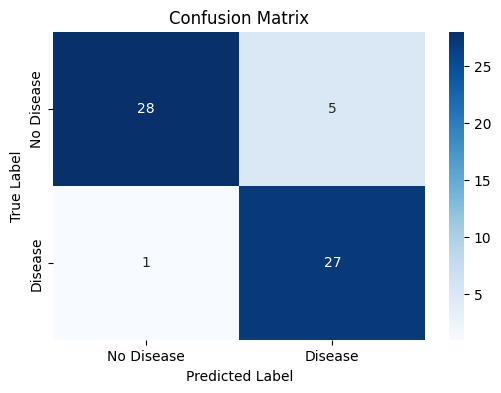

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Replace with your trained model:
model = stack_pipe   # or: best_xgb, smote_pipe, etc.

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# ---- Metrics ----
acc = accuracy_score(y_test, y_pred)
cm  = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)
roc = roc_auc_score(y_test, y_proba)

print("=======================================")
print("           FINAL EVALUATION")
print("=======================================")
print(f"Accuracy       : {acc:.4f}")
print(f"ROC–AUC Score  : {roc:.4f}")
print("\nClassification Report:")
print(report)
print("Confusion Matrix:")
print(cm)

# ---- Confusion Matrix Heatmap ----
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
